In [1]:
import numpy as np
from matplotlib import pyplot as plt

from scipy.spatial.distance import pdist, squareform, cdist

import gym

from tqdm.notebook import tqdm

def angle_normalize(x):
    return ((x + np.pi) % (2 * np.pi)) - np.pi

max_torque = 2.0
max_speed = 8
dt = 0.05
g = 10.0
m = 1.0
l = 1.0

In [12]:
np.sqrt(6.2 * (10**5))

787.4007874011811

In [6]:
grid_dim = 300
n_state = grid_dim**2
action_grid_dim = 100
n_action = action_grid_dim
actions = np.linspace(-max_torque,max_torque,num=action_grid_dim)
speeds = np.linspace(-max_speed,max_speed,num=grid_dim)
angles = np.linspace(-np.pi,np.pi,num=grid_dim)

xx, yy = np.meshgrid(angles,speeds)
xy = np.vstack([xx.reshape(-1),yy.reshape(-1),]).T

xy_norm = np.vstack([xx.reshape(-1)/np.pi,yy.reshape(-1)/max_speed]).T

cost_mat = np.zeros((np.shape(xy)[0],action_grid_dim))

for i,state in tqdm(enumerate(xy)):
    for j,u in enumerate(actions):
        th = state[0]
        thdot = state[1]
        cost_mat[i][j] = angle_normalize(th) ** 2 + 0.1 * thdot**2 + 0.001 * (u**2)
        # cost_mat[i][j] = -np.exp(-10*(angle_normalize(th) ** 2 + 0.2 * thdot**2))

0it [00:00, ?it/s]

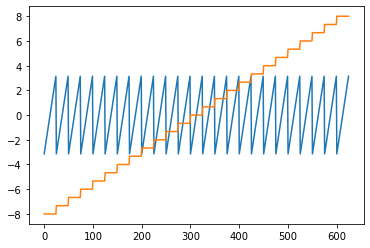

In [5]:
plt.plot(xy)

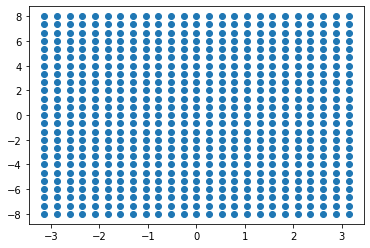

In [6]:
plt.scatter(xy.T[0],xy.T[1])

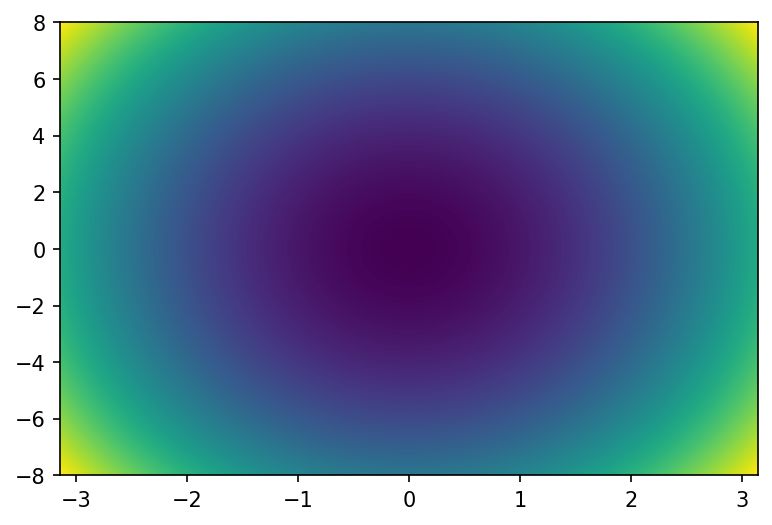

In [3]:
plt.figure(dpi=150)
plt.imshow(np.reshape(cost_mat.T[10],(grid_dim,grid_dim,-1)),origin='lower',extent=[-np.pi,np.pi,-max_speed,max_speed],aspect='auto')

  0%|          | 0/10 [00:00<?, ?it/s]

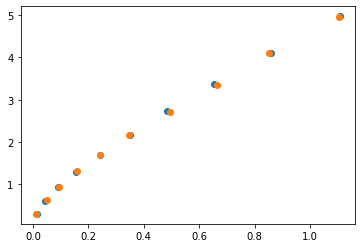

In [7]:
u = actions[-2]

th = 0
thdot = 0

traj_len = 10
traj = np.zeros((traj_len,2))
quant_traj = np.zeros((traj_len,2))

for i in tqdm(range(traj_len)):

    newthdot = thdot + (3 * g / (2 * l) * np.sin(th) + 3.0 / (m * l**2) * u) * dt
    newthdot = np.clip(newthdot, -max_speed, max_speed)
    newth = th + newthdot * dt

    thdot = newthdot
    th = newth

    dists = cdist(xy_norm,np.reshape([newth/np.pi,newthdot/max_speed],(1,-1)),metric='sqeuclidean')
        # dists = cdist(xy,np.reshape([newth,newthdot],(1,-1)),metric='sqeuclidean')
    # xy_next[i][j] = int(np.argmin(dists))
    quant_traj[i] = xy[int(np.argmin(dists))]
    traj[i][0] = newth
    traj[i][1] = newthdot

    # print('newthdot: '+str(newthdot))
    # print('newth: '+str(newth))

plt.scatter(traj.T[0],traj.T[1])
plt.scatter(quant_traj.T[0],quant_traj.T[1])

In [4]:
np.shape(xy)

(40000, 2)

In [8]:
xy_next = np.zeros((np.shape(xy)[0],action_grid_dim),dtype=int)

for i in tqdm(range(len(xy))):
    state = xy[i]
# for i,state in enumerate(xy):
    if not i%1000:
        print(i)
    th = state[0]
    thdot = state[1]
    # print('State :')
    # print(state)
    for j,u in enumerate(actions):
        newthdot = thdot + (3 * g / (2 * l) * np.sin(th) + 3.0 / (m * l**2) * u) * dt
        newthdot = np.clip(newthdot, -max_speed, max_speed)
        newth = th + newthdot * dt

        new_state = np.array([newth, newthdot])

        # print('Action : '+str(u))
        # print('New State')
        # print(new_state)

        dists = cdist(xy_norm,np.reshape([newth/np.pi,newthdot/max_speed],(1,-1)),metric='sqeuclidean')
        # dists = cdist(xy,np.reshape([newth,newthdot],(1,-1)),metric='sqeuclidean')
        xy_next[i][j] = int(np.argmin(dists))

        # print('Quantized State: ')
        # print(xy[xy_next[i][j]])

  0%|          | 0/90000 [00:00<?, ?it/s]

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000


In [14]:
import copy

V_VI = np.zeros(n_state)

theta = 0.001
max_iter = 10000
# max_iter = 10
err = np.infty

gamma = 0.9

iter = 0

deltas = []

VI_policies = []
VI_policy = np.zeros(n_state)
while iter<max_iter and err>theta:
    # print(iter)
    V_temp = np.zeros_like(V_VI)
    # print('V_temp')
    # print(V_temp)
    # print('V')
    # print(V)
    for state in range(n_state):
        # V_prod[labels] = V[labels]
        max_buffer = np.zeros(n_action)
        for action in range(n_action):
            # max_buffer[action] = rewards[state][action] + gamma*(np.dot(V_VI,t_matrix[state][action]))
            max_buffer[action] = cost_mat[state][action] + gamma*(V_VI[xy_next[state][action]])
        V_temp[state] = np.min(max_buffer)
        VI_policy[state] = np.argmin(max_buffer)
    # plt.figure()
    # plt.plot(VI_policy)
    # VI_policies.append(copy.deepcopy(VI_policy))
    # VI_policies.append(VI_policy)
    # print('V_temp')
    # print(V_temp)
    err = np.max(np.abs(V_VI-V_temp))
    deltas.append(err)
    if not iter%10:
        print('Iteration: '+str(iter))
        print('Error: '+str(err))
    V_VI = V_temp    
    iter = iter+1

deltas = np.array(deltas)

Iteration: 0
Error: 16.269604809210982
Iteration: 10
Error: 5.672860425919161
Iteration: 20
Error: 1.6331035033302896
Iteration: 30
Error: 0.5387338050195893
Iteration: 40
Error: 0.1853511602537612
Iteration: 50
Error: 0.06406173564779749
Iteration: 60
Error: 0.01858779801399635
Iteration: 70
Error: 0.006219136729342267
Iteration: 80
Error: 0.002168478893551651


In [56]:
VI_policies

[array([48., 43., 45., ...,  4.,  6.,  1.]),
 array([48., 43., 45., ...,  4.,  6.,  1.])]

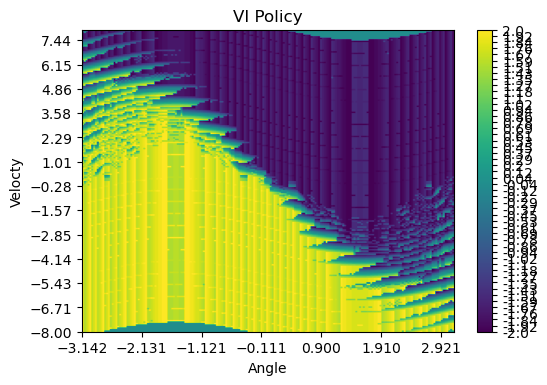

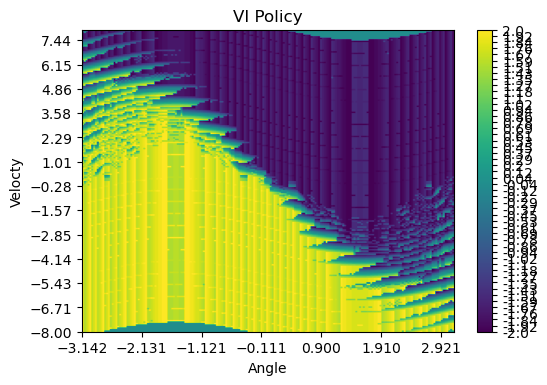

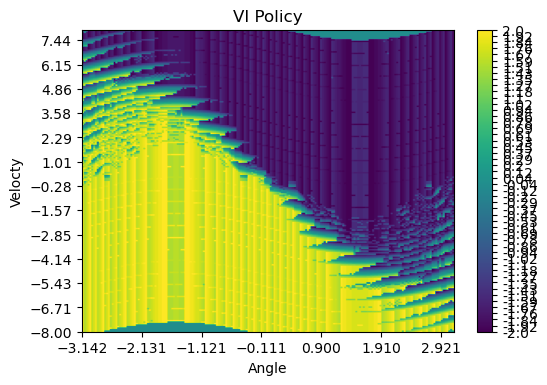

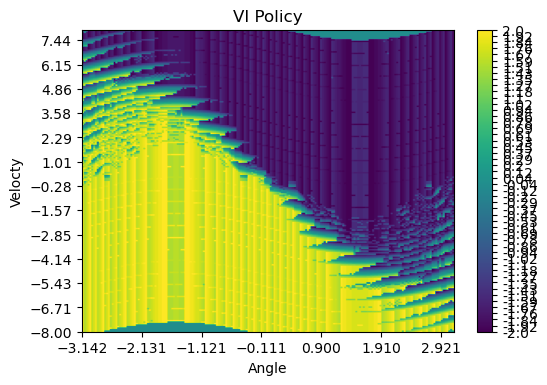

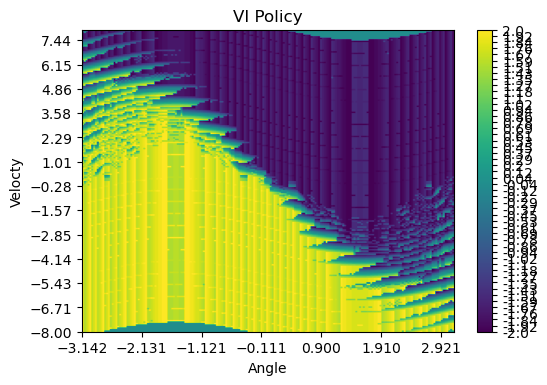

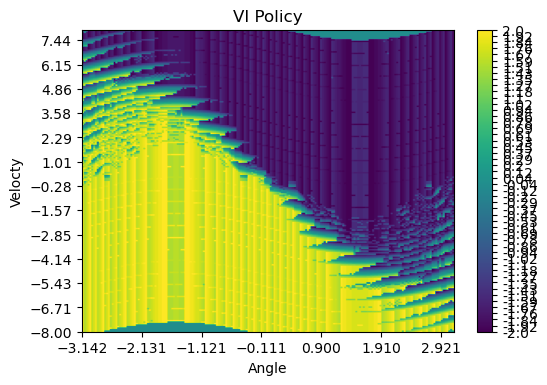

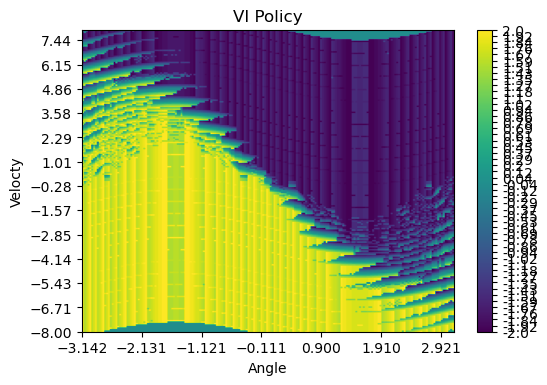

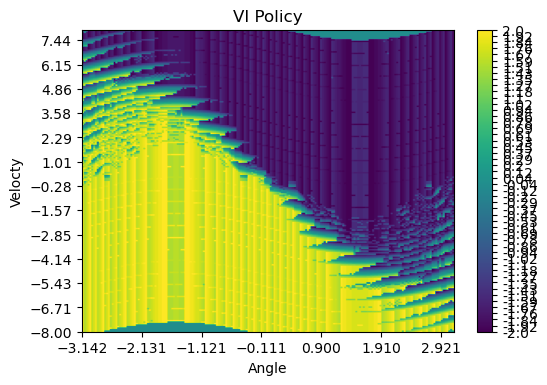

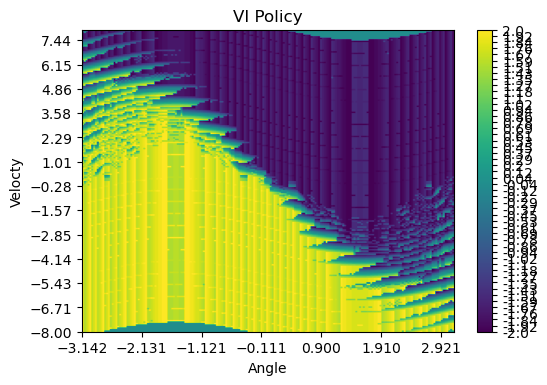

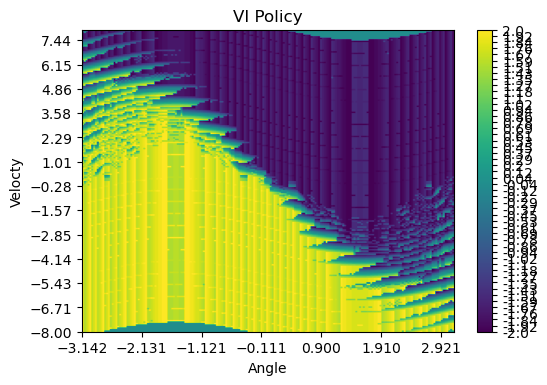

In [39]:
for i in range(10):
    # CME_pol2d = np.reshape(CME_policy,(grid_dim,grid_dim))
    VI_pol2d = np.reshape(VI_policies_arr[i],(grid_dim,grid_dim))
    plt.figure(dpi=100)
    plt.imshow(VI_pol2d,origin='lower',extent=[-np.pi,np.pi,-max_speed,max_speed],aspect='auto')
    plt.title('VI Policy')
    # plt.xticks(range(0,grid_dim,tick_skip))
    # plt.yticks(range(0,grid_dim,tick_skip))
    plt.xticks(angles[0::tick_skip*2])
    plt.yticks(speeds[0::tick_skip])
    plt.xlabel('Angle')
    plt.ylabel('Velocty')
    cbar = plt.colorbar(ticks=range(action_grid_dim));
    cbar.ax.set_yticklabels(np.round(actions,2));

In [15]:
import h5py

with h5py.File('pendulum_model_300s_100a.h5', 'w') as hf:
    hf.create_dataset("actions",  data=actions)
    hf.create_dataset("xy",  data=xy)
    hf.create_dataset("xy_norm",data=xy_norm)
    hf.create_dataset("xy_next",data=xy_next)
    hf.create_dataset("VI_policy",  data=VI_policy)
    hf.create_dataset("VI_val_fcn", data = V_VI)
    hf.create_dataset("g",data = g)

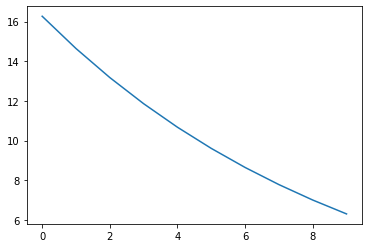

In [12]:
plt.plot(deltas)

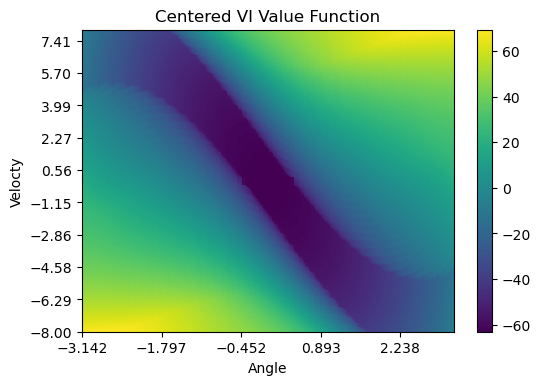

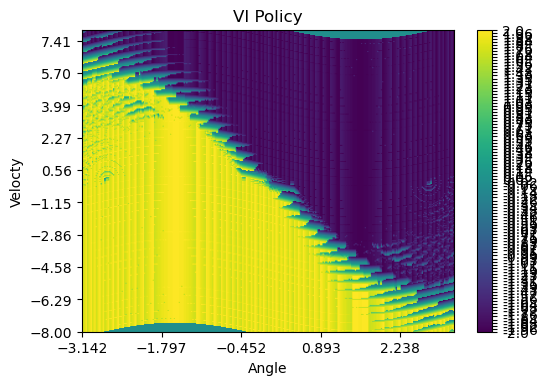

In [19]:
tick_skip = 32

V_VI2d = np.reshape(V_VI-np.mean(V_VI),(grid_dim,grid_dim))
plt.figure(dpi=100)
plt.imshow(V_VI2d,origin='lower',extent=[-np.pi,np.pi,-max_speed,max_speed],aspect='auto')
plt.colorbar()
plt.title('Centered VI Value Function')
# plt.xticks(range(0,grid_dim,tick_skip))
# plt.yticks(range(0,grid_dim,tick_skip))
plt.xticks(angles[0::tick_skip*2])
plt.yticks(speeds[0::tick_skip])
plt.xlabel('Angle')
plt.ylabel('Velocty')
# CME_pol2d = np.reshape(CME_policy,(grid_dim,grid_dim))
VI_pol2d = np.reshape(VI_policy,(grid_dim,grid_dim))
plt.figure(dpi=100)
plt.imshow(VI_pol2d,origin='lower',extent=[-np.pi,np.pi,-max_speed,max_speed],aspect='auto')
plt.title('VI Policy')
# plt.xticks(range(0,grid_dim,tick_skip))
# plt.yticks(range(0,grid_dim,tick_skip))
plt.xticks(angles[0::tick_skip*2])
plt.yticks(speeds[0::tick_skip])
plt.xlabel('Angle')
plt.ylabel('Velocty')
cbar = plt.colorbar(ticks=range(action_grid_dim));
cbar.ax.set_yticklabels(np.round(actions,2));

In [22]:
env =  gym.make('Pendulum-v1', g=g)
obs = env.reset()

state = env.state

dists = cdist(xy_norm,np.reshape([state[0]/np.pi,state[1]/max_speed],(1,-1)),metric='sqeuclidean')
state_q_ind = int(np.argmin(dists))
action = actions[int(VI_policy[state_q_ind])]

while True:

    dists = cdist(xy_norm,np.reshape([state[0]/np.pi,state[1]/max_speed],(1,-1)),metric='sqeuclidean')
    state_q_ind = int(np.argmin(dists))
    action = actions[int(VI_policy[state_q_ind])]

    # q_vals = np.zeros(n_actions)

    # rep_s = np.tile(state,(action_space_quant_points,1))
    # rep_s_a = np.hstack((rep_s,action_space_quant))
    # action_ind = np.argmax(np.dot(get_bases(rep_s_a,w,b),c))
    # action = action_space_quant[action_ind]

    # for act in range(n_actions):
    #     q_vals[act] = np.dot(get_bases(state[np.newaxis,:],w,b),c[act])

    # action = np.argmax(q_vals)
    #ep_actions.append(action)
    env.render()

    next_state, reward, done, _ = env.step(action[np.newaxis])
    # state = next_state
    state = env.state
    
    if done:
        # if state[0]>=0.5:
        #     print('Success!')
        break

env.close()